# Progetto esame Analisi Statistica dei Dati Sperimentali

Lo scopo del seguente progetto è fare un'analisi statistica dei dati riguardanti il transito dell'esopianeta [HD 189733b](https://exoplanet.eu/catalog/hd_189733_ab--307/) davanti alla sua *host star* [HD 189733](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=HD189733&submit=SIMBAD+search).

I transiti degli esopianeti, vale a dire il passaggio del pianeta davanti la stella (la situazione opposta è l'eclissi), sono uno dei principali metodi di indagine delle caratteristiche fisiche e chimiche degli stessi, e note le caratteristiche della stella (massa, raggio, tipo spettrale), si possono ricavare massa e raggio del pianeta, nonché i parametri orbitali del sistema.

La quantità misurata è il flusso $F$, cioè la quantità di energia ricevuta dalla stella che attraversa un'unità di area perpendicolare alla direzione della luce, per unità di tempo, su tutte le lugnhezze d'onda. Questa misura viene effettua per un tempo $t$ maggiore della durata del transito, così da avere informazioni sul flusso normalmente ricevuto dalla stella e poter chiaramente osservare il picco negativo corrispondente all'oscuramento di parte della stella a causa del passaggio del pianeta.

In particolare, il flusso viene fornito come **flusso relativo** tra la *target star* e una stella di riferimento; ciò è dovuto al fatto che il flusso dipende (anche) dalla distanza tra l'astro e l'osservatore. Per questo tipo di analisi, tuttavia, questo non risulta essere un problema, in quanto si è interessati a studiare la variazione del flusso e il cui livello standard può in ogni caso considerarsi come normalizzato ad 1.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
import batman

In [3]:
file_fluxes = 'curva_luce_differenziale.txt'
fluxes = np.loadtxt(file_fluxes, skiprows=1)
print(fluxes)
print(np.shape(fluxes))

[[2.46095729e+06 2.98837459e+06 8.64253213e+05 9.94834941e-01]
 [2.46095729e+06 3.00350966e+06 8.50857032e+05 1.01561578e+00]
 [2.46095729e+06 2.97546782e+06 8.46102052e+05 1.01178796e+00]
 ...
 [2.46095741e+06 2.77751898e+06 7.54403450e+05 1.05927901e+00]
 [2.46095741e+06 2.77491145e+06 7.82652962e+05 1.02008625e+00]
 [2.46095741e+06 2.74123820e+06 7.78004420e+05 1.01372862e+00]]
(485, 4)


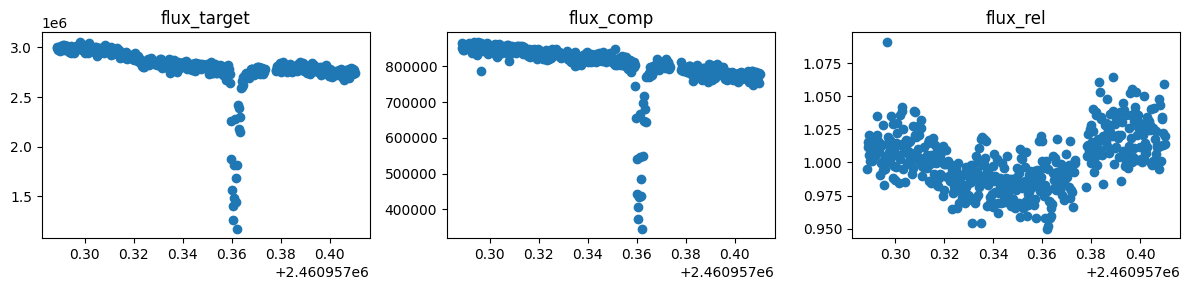

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 3))

ax1.scatter(fluxes[:, 0], fluxes[:, 1])
ax1.set_title('flux_target')
ax2.scatter(fluxes[:, 0], fluxes[:, 2])
ax2.set_title('flux_comp')
ax3.scatter(fluxes[:, 0], fluxes[:, 3])
ax3.set_title('flux_rel')

plt.tight_layout()
plt.show()

Sostanzialmente quello fatto prima è inutile, noi dobbiamo ragionare in termini di flusso, non di magnitudine - perché la magnitudine non è linare. Flux rel è il rapporto tra flux target (la mia stella) e flux comp (stella di comparazione)

In [5]:
df = pd.DataFrame(fluxes)
df.columns = ('jd', 'flux_target', 'flux_comp', 'flux_rel')
df['delta_jd'] = df.loc[:, 'jd'] - df.at[0, 'jd'] #tempo è espresso in JD (Julian Day)
df['time'] = df.loc[:, 'delta_jd']*86400 #per transformare l'intervallo di tempo in secondi va moltiplicato per 86400

In [20]:
def line(x, m, b):
    return m*x + b


target10 = df.loc[:, 'flux_target'].to_numpy()
target10 = np.concatenate([target10[:100], target10[-100:]])

time10 = df.loc[:, 'time'].to_numpy()
time10 = np.concatenate([time10[:100], time10[-100:]])

comp10 = df.loc[:, 'flux_comp'].to_numpy()
comp10 = np.concatenate([target10[:100], target10[-100:]])

sigma_target10 = np.ones_like(target10)
leastsquares_target = LeastSquares(time10, target10, sigma_target10, line)

sigma_comp10 = np.ones_like(comp10)
leastsquares_comp = LeastSquares(time10, comp10, sigma_target10, line)

fit_target = Minuit(leastsquares_target, m=0.0, b=0.0)
fit_target.migrad()
fit_target.hesse()

fit_comp = Minuit(leastsquares10, m=0.0, b=0.0)
fit_comp.migrad()
fit_comp.hesse()

print(f'fit su target: {fit_target.values}')
print(f'errori su target: {fit_target.errors}')

print(f'fit su comparison: {fit_comp.values}')
print(f'errori su comparison: {fit_comp.errors}')

fit su target: <ValueView m=-25.84126731107466 b=3011299.061931463>
errori su target: <ErrorView m=1.6588868316003604e-05 b=0.11228435296795478>
fit su comparison: <ValueView m=-22.168974752575537 b=2991729.215083136>
errori su comparison: <ErrorView m=4.330505687055366e-05 b=0.3191197221083176>


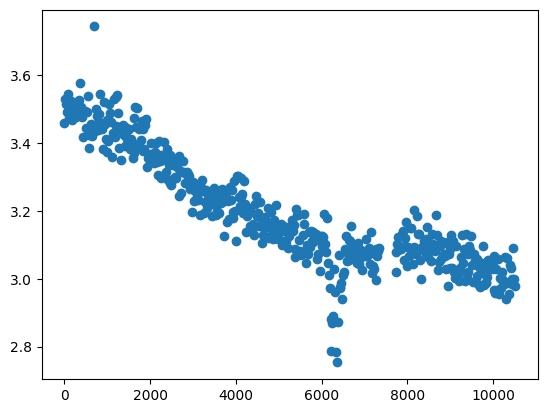

114119.76324397091 114119.76324397091


In [28]:
mtarget = fit_target.values['m']
btarget = fit_target.values['b']

mcomp = fit_comp.values['m']
bcomp = fit_comp.values['b']

df['target_fit'] = df.loc[:, 'flux_target'] - mtarget*df.loc[:, 'time']
df['comp_fit'] = df.loc[:, 'flux_comp'] - mcomp*df.loc[:, 'time']

df['flu']

#plt.scatter(df['time'], df['target_fit'])
#plt.scatter(df['time'], df['comp_fit'])
plt.scatter(df['time'], df['target_fit']/df['comp_fit'])
plt.show()

mean_target = np.mean(target10)
std_target = np.std(target10, ddof=2)

mean_comp = np.mean(comp10)
std_comp = np.std(comp10, ddof=2)

print(std_target, std_comp)

# INIZIA QUI

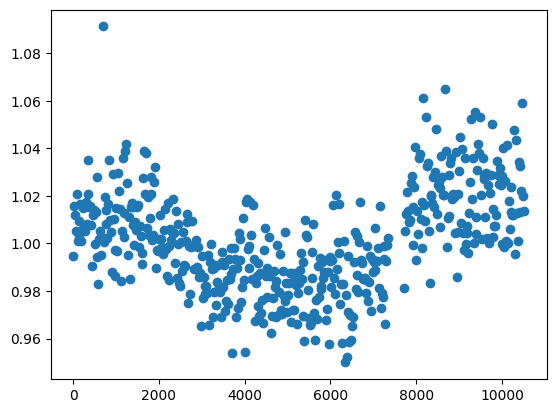

In [40]:
plt.scatter(df['time'], df['flux_rel'])
plt.show()

#dati storti quindi li raddrizzo
#il flusso tra l'altro non richiede l'inversione rognosa delle y

In [41]:
#Osservazione: quel punto con y>1.08 è chiaramente un aereo o simile
#Lo elimino

plane = df.loc[df['flux_rel'] > 1.08].index
df = df.drop(plane)
df

,jd,flux_target,flux_comp,flux_rel,delta_jd,time
0,2.460957e+06,2.988375e+06,864253.212792,0.994835,0.000000,0.000000
1,2.460957e+06,3.003510e+06,850857.032319,1.015616,0.000242,20.941991
2,2.460957e+06,2.975468e+06,846102.052065,1.011788,0.000485,41.899994
3,2.460957e+06,2.993793e+06,856728.636066,1.005392,0.000727,62.854980
4,2.460957e+06,2.999282e+06,845414.238789,1.020716,0.000971,83.863999
...,...,...,...,...,...,...
480,2.460957e+06,2.746320e+06,779782.078643,1.013293,0.120732,10431.207995
481,2.460957e+06,2.732141e+06,769137.687283,1.022012,0.120975,10452.199996
482,2.460957e+06,2.777519e+06,754403.450482,1.059279,0.121218,10473.217987
483,2.460957e+06,2.774911e+06,782652.962095,1.020086,0.121460,10494.158971


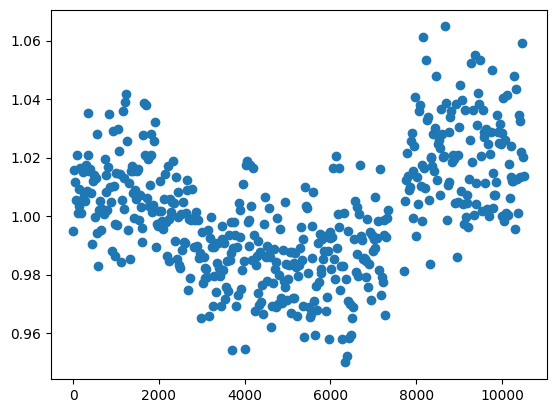

In [42]:
plt.scatter(df['time'], df['flux_rel'])
plt.show()

In [43]:
def line(x, m, b):
    return m*x + b

flux10 = df.loc[:, 'flux_rel'].to_numpy()
flux10 = np.concatenate([flux10[:10], flux10[-10:]])

time10 = df.loc[:, 'time'].to_numpy()
time10 = np.concatenate([time10[:10], time10[-10:]])

sigma_flux10 = np.ones_like(flux10)
leastsquares10 = LeastSquares(time10, flux10, sigma_flux10, line)

fit10 = Minuit(leastsquares10, m=0.0, b=0.0)
fit10.migrad()
fit10.hesse()

print(fit10.values)
print(fit10.errors)

#farlo con Minuit ha più senso; quello che noi stiamo facendo è banalmente un fit lineare per raddrizzare i dati
#siccome non abbiamo idea sugli errori, prendiamo come punti solo i primi e gli ultimi 10 punti
#perchè prendendo più punti saranno influenzati dal fatto che noi non abbiamo (ancora) idea di quale sia la forma funzionale

<ValueView m=1.674890837134865e-06 b=1.007798332695096>
<ErrorView m=4.330507992879252e-05 b=0.31911980609944446>


In [44]:
mfit10 = fit10.values['m']
bfit10 = fit10.values['b']

df['flux_fit'] = df.loc[:, 'flux_rel'] - mfit10*df.loc[:, 'time']

df

,jd,flux_target,flux_comp,flux_rel,delta_jd,time,flux_fit
0,2.460957e+06,2.988375e+06,864253.212792,0.994835,0.000000,0.000000,0.994835
1,2.460957e+06,3.003510e+06,850857.032319,1.015616,0.000242,20.941991,1.015581
2,2.460957e+06,2.975468e+06,846102.052065,1.011788,0.000485,41.899994,1.011718
3,2.460957e+06,2.993793e+06,856728.636066,1.005392,0.000727,62.854980,1.005287
4,2.460957e+06,2.999282e+06,845414.238789,1.020716,0.000971,83.863999,1.020575
...,...,...,...,...,...,...,...
480,2.460957e+06,2.746320e+06,779782.078643,1.013293,0.120732,10431.207995,0.995821
481,2.460957e+06,2.732141e+06,769137.687283,1.022012,0.120975,10452.199996,1.004506
482,2.460957e+06,2.777519e+06,754403.450482,1.059279,0.121218,10473.217987,1.041738
483,2.460957e+06,2.774911e+06,782652.962095,1.020086,0.121460,10494.158971,1.002510


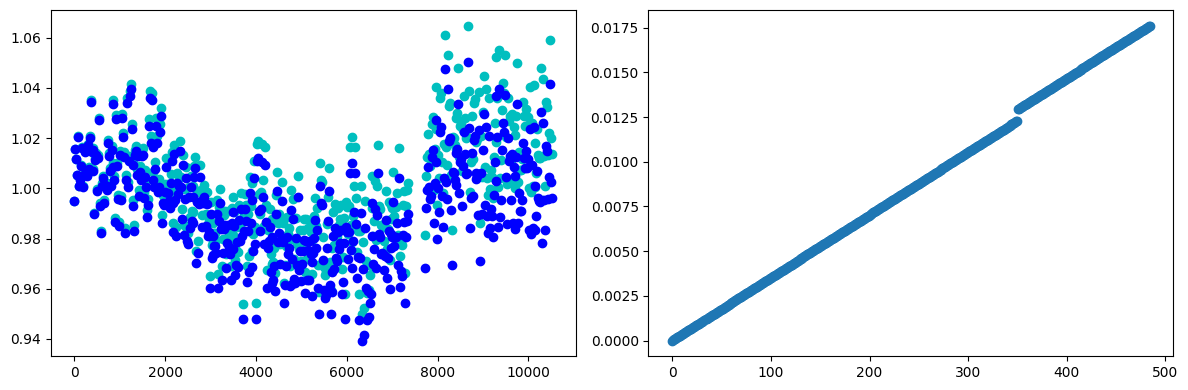

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.scatter(df['time'], df['flux_rel'], c='c')
ax1.scatter(df['time'], df['flux_fit'], c='b')

ax2.scatter(df.index, df['flux_rel']-df['flux_fit'])

plt.tight_layout()
plt.show()

#l'unica cosa che non mi spiego è questo stupido gap

(quando avremo finito mettiamo qua i calcoli fatti per ricavare la relazione funzionale)

$\displaystyle F(t)=\begin{cases}
    F_0 & t \leq t_1 \land t \geq t_4 & \text{(pre- e post-transito)} \\
    F_0 - \delta \left(\frac{t - t_1}{\tau}\right) & t_1 < t \leq t_2 & \text{(ingresso)}\\
    F_0 - \delta & t_2 < t \leq t_3 & \text{(eclissi)}\\
    F_0 + \delta \left(1 - \frac{t - t_3}{\tau}\right) & t_3 < t < t_4 & \text{(uscita)}\\
    \end{cases}$

* $F_0$ livello normale del flusso, da normalizzare
* $t_0$ tempo del minimo, centro transito
* $\delta$ profondità del flusso
* $\tau = t_2 - t_1 = t_4 - t_3$, durata in-out

Nella scrittura del modello eviterei $\tau$ perché (per motivi di errorri sul flusso) non è detto che le due differenze siano uguali

In [46]:
#numpy.piecewise(x, condlist, funclist, *args, **kw)

def piecewise(t, F0, F1, t0, T, tau):
    t1, t2, t3, t4 = t0 - 0.5*T, t0 - 0.5*T + tau, t0 + 0.5*T - tau, t0 + 0.5*T
    deltaF = F0 - F1
    return np.piecewise(t,
        [
            (t <= t1) | (t >= t4),
            (t > t1) & (t <= t2),
            (t > t2) & (t <= t3),
            (t > t3) & (t < t4)
        ],
        [
            lambda t: F0,
            lambda t: F0 - deltaF * (t - t1) / tau,
            lambda t: F0 - deltaF,
            lambda t: F0 - deltaF + deltaF * (t - t3) / tau
        ])

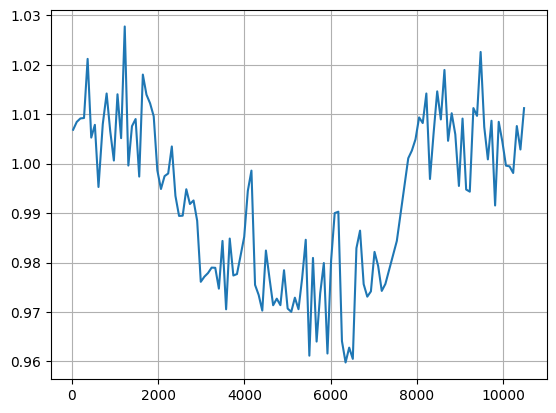

In [13]:
#dato che Minuit vuole un first guess per ogni parametro, facciamo una media ogni 4pt per avere un'idea approssimata dei vari F0, tau
#485/4=121
t4 = np.mean(np.reshape(df['time'], (121, 4)), axis=1)
flux4 = np.mean(np.reshape(df['flux_fit'], (121, 4)), axis=1)

plt.plot(t4, flux4)
plt.grid()
plt.show()

In [14]:
#vediamo quindi i nostri first guesses
#F0, F1, t0, T, tau
guesses = [1.005, 0.975, 5000, 6000, 1000]

In [15]:
time = df['time']
flux = df['flux_fit']
sigmaflux = np.ones_like(flux)

lsquaresflux = LeastSquares(time, flux, sigmaflux, piecewise)
mF = Minuit(lsquaresflux,
            F0=guesses[0], F1=guesses[1], t0=guesses[2], T=guesses[3], tau=guesses[4])
mF.migrad()
mF.hesse()

params1 = np.array([*mF.values])
err1 = np.array([*mF.errors])

for i in range(len(params1)):
    print(f'{params1[i]:.5f} +- {err1[i]:.5f}')

print(f'delta F: {params1[0] - params1[1]:.5f} +- {err1[0] + err1[1]:.5f}')

1.00689 +- 0.06871
0.97642 +- 0.07198
5097.89512 +- 3829.35410
6060.31796 +- 12957.31269
1004.46037 +- 10950.61344
delta F: 0.03047 +- 0.14069


`F0` ha un valore e un errore sostanzialmente accettabili, tutti gli altri dati hanno errori troppo alti.

Gli errori sui singoli punti per quanto riguarda il flusso possiamo calcolarli considerando i punti come variabili gaussiane distribuite attorno al valore medio $\mu = F(t)$, l'errore diventa allora $\sigma$.

A questo punto io proseguirei usando magari il pacchetto `batman` per il transito di esopianeti, e usarlo per stimare parametri interessanti, usando come dati quelli ottenuti da questo.

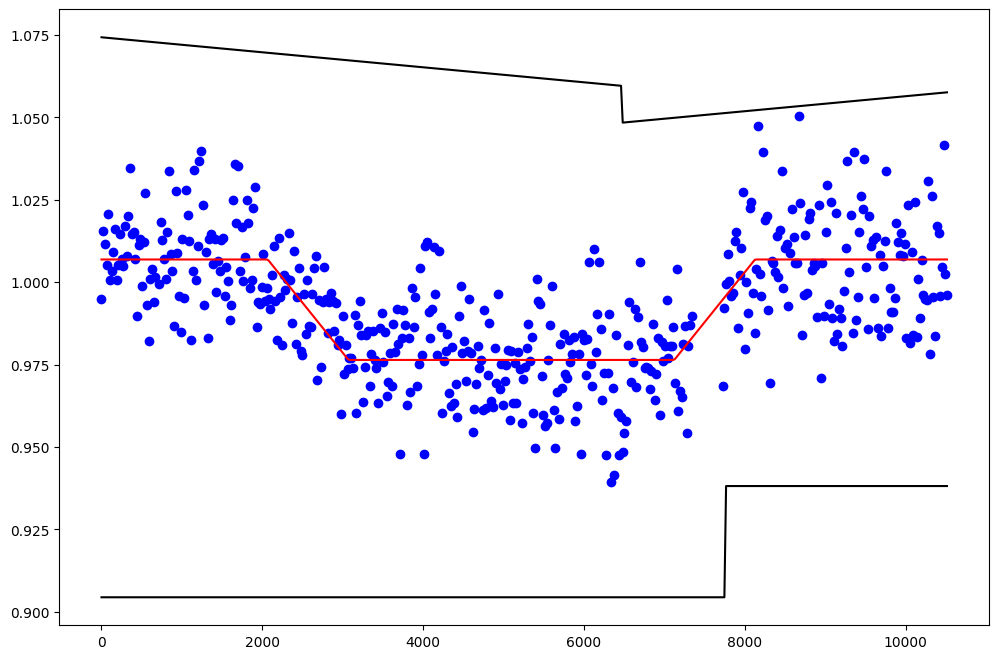

In [16]:
Ft1 = piecewise(np.array(time), *mF.values)

params1_low = params1 - err1
params1_high  = params1 + err1

Ft1_low = piecewise(np.array(time), *params1_low)
Ft1_high = piecewise(np.array(time), *params1_high)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(time, flux, c='b')
ax.plot(time, Ft1, c='r')
ax.plot(time, Ft1_low, c='k')
ax.plot(time, Ft1_high, c='k')
plt.show()

I parametri sopra non sono un granché, tranne $F_0$; andiamo allora a usare questo valore per stimare gli errori sulle $y$ come residui:

$\varepsilon_i = y_i - \hat{y}_i$, dove $\hat{y}_i = F(t)$.

$\displaystyle \widehat{\sigma^2} = \frac{1}{N - D} \left \langle \varepsilon^2 \right \rangle$, con $N$ le misure e $D$ il numero di parametri determinati dal fit; $N - D = k$ gradi di libertà.

$\left \langle \varepsilon^2 \right \rangle = \sum_i \varepsilon_i^2$ (non abbiamo bisogno dei pesi $w_i$ perché consideriamo tutti i $\sigma_i$ uguali tra loro).

In [17]:
res = flux - Ft1
res2 = np.square(res)
N, D = len(flux), len(params1)
k = N - D
var_flux = np.sum(res2)/k
sigmafluxhat = np.sqrt(var_flux)
print(sigmafluxhat)
print(np.mean(res))

0.014488616904764101
1.1515938764557646e-05


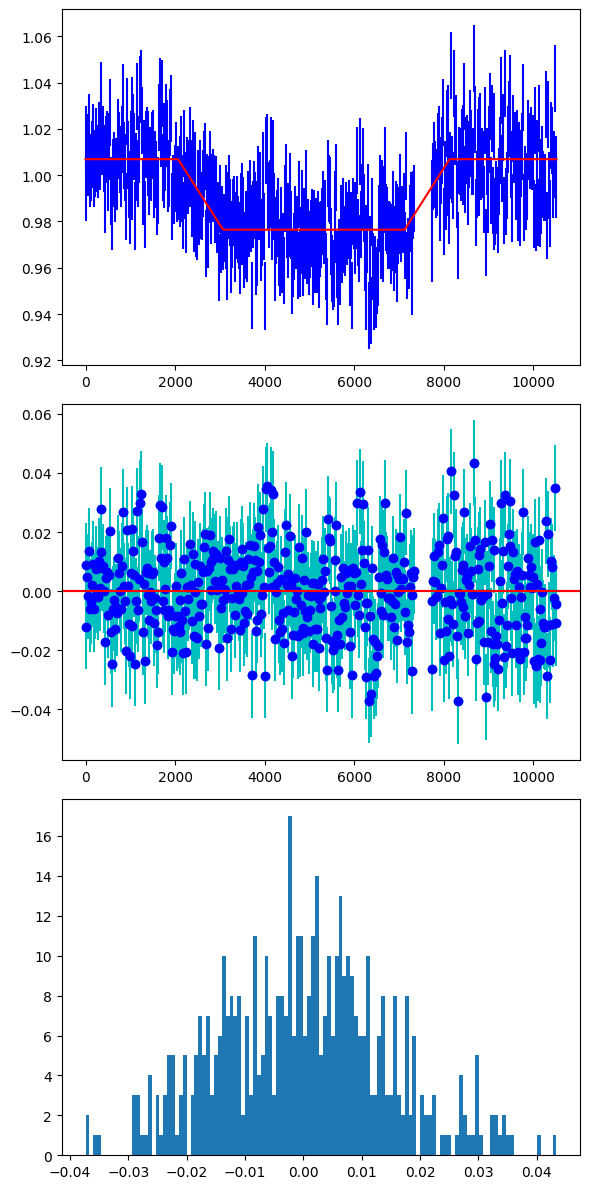

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))
ax1.errorbar(time, flux, yerr=sigmafluxhat, c='b', linestyle='')
ax1.plot(time, Ft1, c='r')
ax2.errorbar(time, res, yerr=sigmafluxhat, c='c', fmt='o', zorder=0)
ax2.scatter(time, res, c='b', zorder=1)
ax2.axhline(0, c='r', zorder=2)
ax2.axhline(np.mean(res), c='r')
ax3.hist(res, bins=121)
plt.tight_layout()
plt.show()
plt.show()

In [19]:
#NON USARE QUESTI DATI
#SONO A SCOPO DIMOSTRATIVO
#questa è una seconda run del fit usando F0 precedentemente ricavato
#allo scopo di verificare se i parametri migliorano.
#Non migliorano lol

lsquaresflux2 = LeastSquares(time, flux, sigmafluxhat, piecewise)
mF2 = Minuit(lsquaresflux, *params1)
mF2.fixed['F0'] = True
mF2.migrad()
mF2.hesse()

params2 = np.array([*mF2.values])
err2 = np.array([*mF2.errors])

for i in range(len(params1)):
    print(f'old: {params1[i]:.5f} +- {err1[i]:.5f},\n new: {params2[i]:.5f} +- {err2[i]:.5f}\n')

old: 1.00689 +- 0.06871,
 new: 1.00689 +- 0.01007

old: 0.97642 +- 0.07198,
 new: 0.97638 +- 0.07452

old: 5097.89512 +- 3829.35410,
 new: 5044.39112 +- 4101.44674

old: 6060.31796 +- 12957.31269,
 new: 6263.05992 +- 14598.93024

old: 1004.46037 +- 10950.61344,
 new: 1238.24497 +- 12721.76668



In [20]:
#NON USARE
Ft2 = piecewise(np.array(time), *params2)
params2_low = params2 - err2
params2_high  = params2 + err2

Ft2_low = piecewise(np.array(time), *params2_low)
Ft2_high = piecewise(np.array(time), *params2_high)

res_2 = flux - Ft2
res_22 = np.square(res_2)
var_flux2 = np.sum(res_22)/k
sigmafluxhat2 = np.sqrt(var_flux2)
print(sigmafluxhat2)

0.014467410090290329


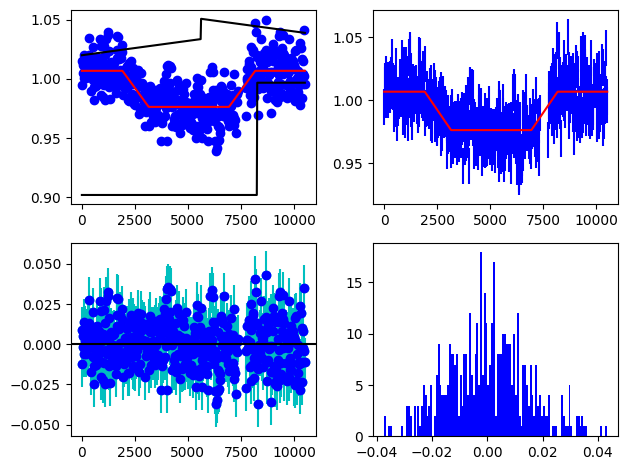

In [21]:
#NON USARE
fig, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(nrows=2, ncols=2)

ax1.scatter(time, flux, c='b')
ax1.plot(time, Ft2, c='r')
ax1.plot(time, Ft2_low, c='k')
ax1.plot(time, Ft2_high, c='k')

ax2.errorbar(time, flux, yerr=sigmafluxhat2, c='b', linestyle='')
ax2.plot(time, Ft2, c='r')

ax3.errorbar(time, res_2, yerr=sigmafluxhat2, c='c', fmt='o', zorder=0)
ax3.scatter(time, res_2, c='b', zorder=1)
ax3.axhline(0, c='k', zorder=2)

ax4.hist(res_2, bins=121, color='b')

plt.tight_layout()
plt.show()
plt.show()

In [22]:
F0, F1, t0, T, tau = params1

Batman: plot con andamento teorico, evidenziare che pt non si dispongono, plot con limb darkening (atmosfere stelle hanno lunghezza ottica diversa)

***

$\displaystyle T_\text{dur} = \frac{P}{\pi} \arcsin{\left(\frac{\sqrt{(R_* + R_P)^2 - a^2 \cos{i}^2}}{a}\right)}$

$P$ è il periodo, $i$ angolo di inclinazione, $a$ è il semiasse maggiore

***

Per $a \gg R_* \gg R_P$, $\displaystyle T_\text{dur} \simeq \frac{P}{\pi} \sqrt{\left(\frac{R_*}{a}\right)^2 -\cos{i}^2}$

Sapendo il tipo di stella, $M_*, R_*$ sono ricavabili dal diagramma HR

$T_\text{dur}, P$ sufficienti a dedurre l'angolo

# Stima della raggio del pianeta

* $k = R_p / R_\star$, $\delta F = (F_0 - F_1)/F_0$
* $F_p / F_\star = k^2 I_p/I_\star$, dove $I_p, I_\star$ sono le intensità mediate sulla superficie
* $\delta F \approx k^2 (1 - I_p/I_\star) \approx k^2$ perché durante il transito supponiamo che $I_p \approx 0$ perché il pianeta non è illuminato
* $R_p \approx R_\star \sqrt{\delta F}$

In [23]:
#unità Rsun
Rstar =  0.805
Rstarerr = 0.016

Rjupiter = 9.955 #in Rsun unit

F0err = err1[0]
F1err = err1[1]

deltaF_norm = (F0 - F1)/F0
deltaF_normerr = F0err*(F1/(F0**2)) + F1err*(1/F0)

Rp = Rstar*np.sqrt(deltaF_norm)*Rjupiter
Rperr = (deltaF_normerr*Rstar/(2*np.sqrt(deltaF_norm)) + Rstarerr*np.sqrt(deltaF_norm))*Rjupiter

print(f'raggio pianeta: {Rp:.3f} +- {Rperr:.3f}')
print(f'raggio nominale: {1.138} +- {0.077}')

raggio pianeta: 1.394 +- 3.199
raggio nominale: 1.138 +- 0.077


# Stima della massa del pianeta

* $\frac{M_p}{(M_p + M_\star)^{2/3}} = \frac{K_\star \sqrt{1 - e^2}}{\sin i} (\frac{P}{2\pi G})^{1/3}$
* $M_p \ll M_\star \implies M_p + M_\star \approx M_\star$
* L'osservazione del transito degli esopianeti ha un bias intrinseco verso pianeti con un angolo di inclinazione $i$ tale che $\sin i \approx 1$
* L'eccentricità dell'orbita $e$ viene approssimata come $0$
* Il periodo $P$ lo consideriamo come noto, perché richiede osservazioni ripetute per essere noto
* La semiampiezza della velocità radiale $K$ viene anch'essa ritenuta nota perché richiede analisi ripetute di curve di luce e degli spettri della stella e del sistema
* $M_p \approx M_\star^{2/3} K (\frac{P}{2\pi G})^{1/3}$

Non vi sono dati sugli errori di alcune grandezze.

In [24]:
#unità Msun
Mstar = 0.8
Mstarerr = 0.4

Mjupiter = 9.547919*(10**(-4)) #in Msun unit

K = 0.205 #km/s
P = 2.2185757*86400 #day*s
G = 1.32712440021*(10**(11)) #km^3 Msun^(-1) s^(-2)

Mp = Mstar**(2/3)*K*((P/(2*np.pi*G))**(1/3))/Mjupiter

print(f'massa pianeta: {Mp:.3f}')
print(f'massa nominale: {1.138}')

massa pianeta: 1.133
massa nominale: 1.138


# Stima del semiasse maggiore

* $\frac{a}{R_\star} = \frac{2 \delta F^{1/4}}{\sqrt{\sin^2\left(\frac{\pi T}{P}\right) - \sin^2\left(\frac{\pi (T - 2\tau)}{P}\right)}}$
* $a = R_\star \frac{2 \delta F^{1/4}}{\sqrt{\sin^2\left(\frac{\pi T}{P}\right) - \sin^2\left(\frac{\pi (T - 2\tau)}{P}\right)}}$

In [25]:
a = Rstar*(2*deltaF_norm**(1/4))/(np.sqrt(np.sin(np.pi*T/P)**2 - np.sin(np.pi*(T - 2*tau)/P)**2))
print(f'semiasse maggiore: {a:.5f}')
print(f'semiasse nominale: {6.6631235509:.5f}')

semiasse maggiore: 9.11226
semiasse nominale: 6.66312


# Limb Darkening

Richiede una serie di parametri della stella e del telescopio:
* $T_\text{eff} = 4875\ \text{K}$
* $Z = -0.03$ (log[M/H])
* $\log \text{g} = 4.54$
* $\xi = 2.0$ microturbolence velocity

Dato che non sono stati usati filtri, assumiamo un generico filtro V (visibile)

La formula per il quadratic limb darkening è $I_\star \propto 1 − u_1(1 − \mu) − u_2(1 − \mu)^2$

Usiamo `batman` per modellizzare una curva di luce

In [26]:
u1_quad, u2_quad = 0.7575, 0.0534

paramsB = batman.TransitParams()
paramsB.t0 = t0 #congiunzione inferiore
paramsB.per = P #periodo
paramsB.rp = (Rp/Rjupiter)/Rstar #planet radius (in units of stellar radii)
paramsB.a = a/Rstar #semi-major axis (in units of stellar radii)
paramsB.inc = 90 #inclinazione orbitale (in gradi)
paramsB.ecc = 0 #eccentricità
paramsB.w = 20 #longitudine del periastron (in gradi)
paramsB.u = [u1_quad, u2_quad] #limb darkening coefficients [u1, u2]
paramsB.limb_dark = 'quadratic' #limb darkening model

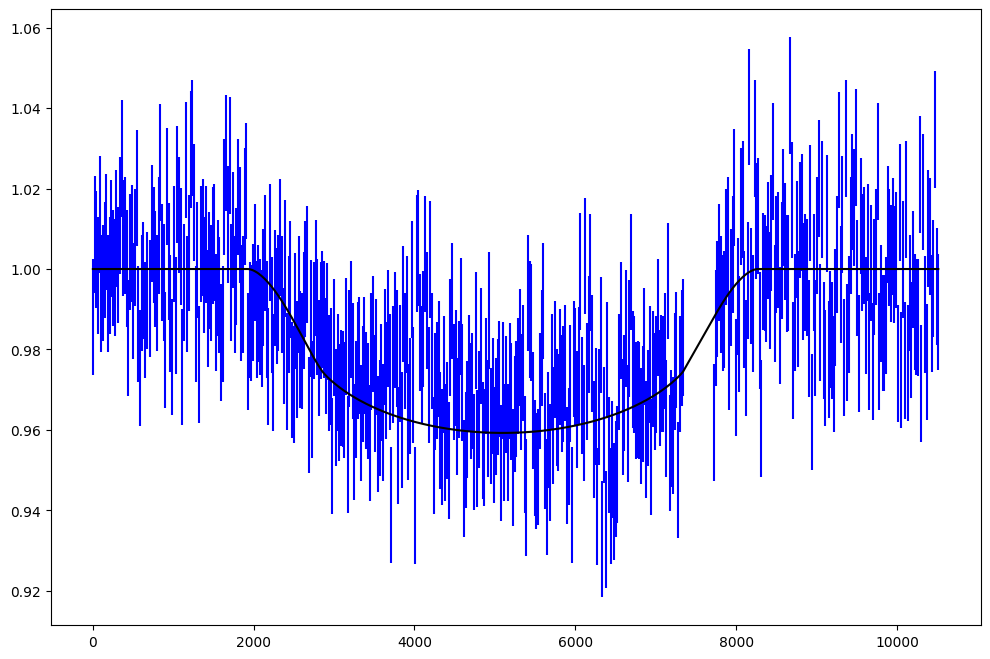

In [27]:
mB = batman.TransitModel(paramsB, np.array(time))
FB = mB.light_curve(paramsB)

fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(time, flux/F0, yerr=sigmafluxhat, c='b', linestyle='')
ax.plot(time, FB, c='k')
plt.show()

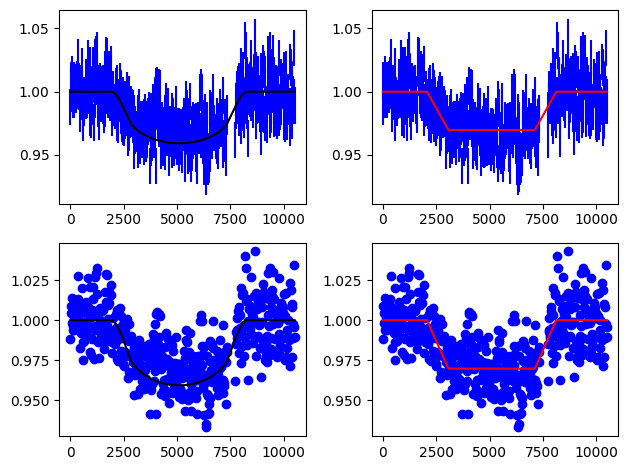

In [28]:
fig, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(nrows=2, ncols=2)

ax1.errorbar(time, flux/F0, yerr=sigmafluxhat, c='b', linestyle='')
ax1.plot(time, FB, c='k')

ax2.errorbar(time, flux/F0, yerr=sigmafluxhat, c='b', linestyle='')
ax2.plot(time, Ft1/F0, c='r')

ax3.scatter(time, flux/F0, c='b')
ax3.plot(time, FB, c='k')

ax4.scatter(time, flux/F0, c='b')
ax4.plot(time, Ft1/F0, c='r')

plt.tight_layout()
plt.show()

In [29]:
resB = flux - FB*F0
resB2 = np.square(resB)
var_fluxB = np.sum(resB2)/k
sigmafluxhatB = np.sqrt(var_fluxB)
print(sigmafluxhatB)
print(np.mean(resB))

0.01522233491145507
0.0029328193797625596


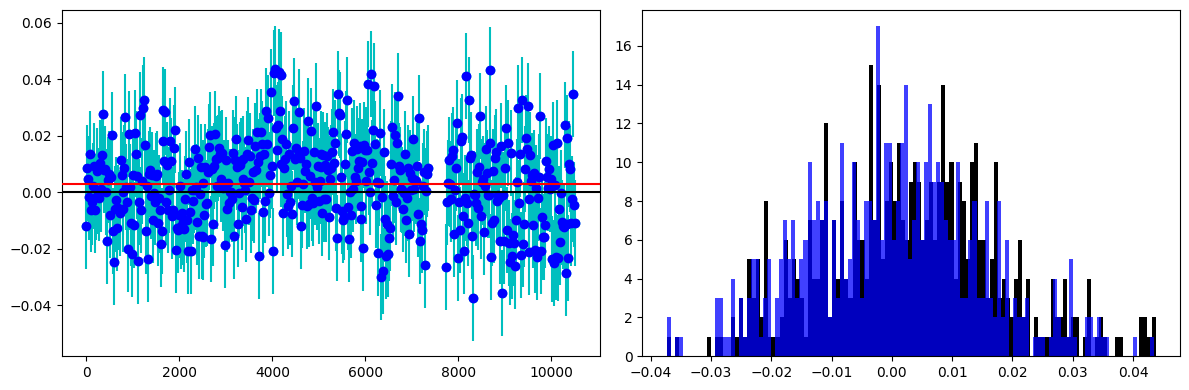

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.errorbar(time, resB, yerr=sigmafluxhatB, c='c', fmt='o', zorder=0)
ax1.scatter(time, resB, c='b', zorder=1)
ax1.axhline(0, c='k', zorder=2)
ax1.axhline(np.mean(resB), c='r', zorder=3)

ax2.hist(resB, bins=121, color='k')
ax2.hist(res, bins=121, color='b', alpha=0.75)

plt.tight_layout()
plt.show()

L'aggiunta del Limb Darkening migliora il fit, ma causa una sottostima. Proviamo con diversi modelli.

model: squareroot
 sigma flux: 0.01523, media res: 0.00294
model: logarithmic
 sigma flux: 0.01507, media res: 0.00270


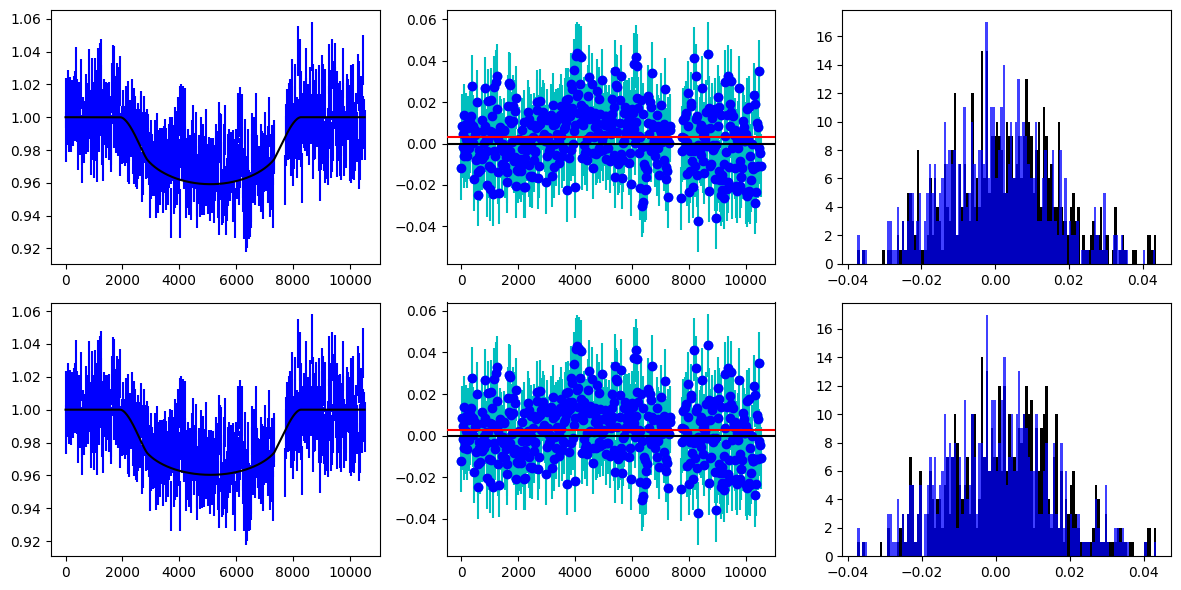

In [31]:
u1_sqrt, u2_sqrt = 0.7016, 0.1376
u1_log, u2_log = 0.8208, 0.0554
limb_dark = ['squareroot', 'logarithmic']
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
rows = [[ax1, ax2, ax3], [ax4, ax5, ax6]]

for i in range(2):
    paramsB.limb_dark = limb_dark[i]
    mB = batman.TransitModel(paramsB, np.array(time))
    FB = mB.light_curve(paramsB)
    
    resB = flux - FB*F0
    resB2 = np.square(resB)
    var_fluxB = np.sum(resB2)/k
    sigmafluxhatB = np.sqrt(var_fluxB)

    current_ax = rows[i]
    
    for j, ax in enumerate(current_ax):
        if j == 0:
            ax.errorbar(time, flux/F0, yerr=sigmafluxhatB, c='b', linestyle='')
            ax.plot(time, FB, c='k')
        elif j == 1:
            ax.errorbar(time, resB, yerr=sigmafluxhatB, c='c', fmt='o', zorder=0)
            ax.scatter(time, resB, c='b', zorder=1)
            ax.axhline(0, c='k', zorder=2)
            ax.axhline(np.mean(resB), c='r', zorder=3)
        elif j == 2:
            ax.hist(resB, bins=121, color='k')
            ax.hist(res, bins=121, color='b', alpha=0.75)
    
    print(f'model: {limb_dark[i]}\n sigma flux: {sigmafluxhatB:.5f}, media res: {np.mean(resB):.5f}')

plt.tight_layout()
plt.show()

# Riduzione errore

Implementare 2° grafico Giuseppe, diminuzione errore

In [67]:
N = 500 #N transiti
deltaFs = []
paramsMC = dict(F0=params1[0], deltaF=params1[0]-params1[1], t0=params1[2], T=params1[3], tau=params1[4]) #starting params

def piecewiseMC(t, F0, deltaF, t0, T, tau):
    t1, t2, t3, t4 = t0 - 0.5*T, t0 - 0.5*T + tau, t0 + 0.5*T - tau, t0 + 0.5*T
    return np.piecewise(t,
        [
            (t <= t1) | (t >= t4),
            (t > t1) & (t <= t2),
            (t > t2) & (t <= t3),
            (t > t3) & (t < t4)
        ],
        [
            lambda t: F0,
            lambda t: F0 - deltaF * (t - t1) / tau,
            lambda t: F0 - deltaF,
            lambda t: F0 - deltaF + deltaF * (t - t3) / tau
        ])


for i in range(N):
    Fsim = piecewiseMC(np.array(time), **paramsMC) + np.random.normal(0, sigmafluxhat, size=len(time))
    paramsMC0 = [params_best['F0'], paramsMC['deltaF'], paramsMC['t0'], params_best['T'], params_best['tau']] #interating params
    
    lsquaresMC = LeastSquares(time, Fsim, sigmafluxhat, piecewiseMC)
    msim = Minuit(lsquaresMC, *paramsMC0)
    
    msim.limits['F0']   = (0.5, 2.0)
    msim.limits['deltaF'] = (0, 0.5)
    msim.limits['t0']   = (time.min(), time.max())
    msim.limits['T']    = (0, time.max() - time.min())
    msim.limits['tau']  = (0, (time.max() - time.min())/2)

    try:
        msim.migrad()
        if not msim.valid:
            continue

        paramsopt = msim.values #optimal params
        deltaFs.append(paramsopt[1])
                            
    except Exception:
        continue

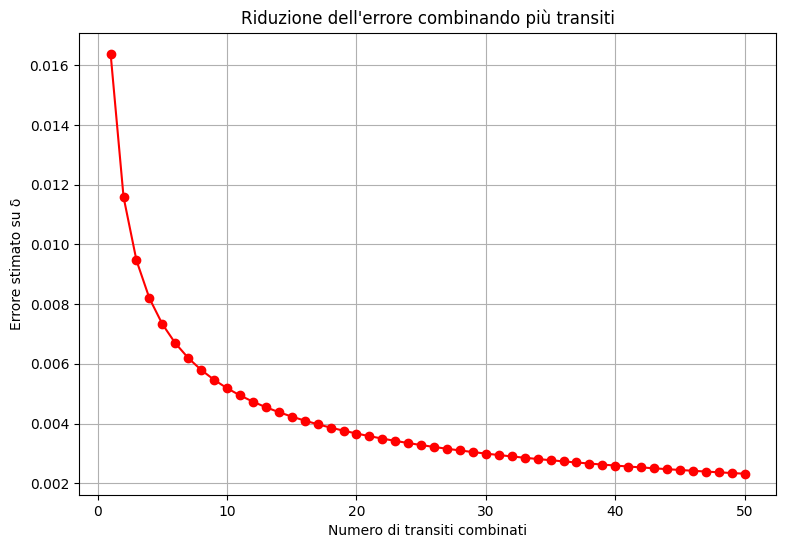


 combinanzione transiti:
 1 transiti errore su δ ≈ 0.01639
 2 transiti errore su δ ≈ 0.01159
 5 transiti errore su δ ≈ 0.00733
10 transiti errore su δ ≈ 0.00518
20 transiti errore su δ ≈ 0.00367
50 transiti errore su δ ≈ 0.00232


In [71]:
deltaFsmean = np.mean(deltaFs)
stddeltaFs = np.std(deltaFs, ddof=k)

Nstack = np.arange(1, 51)
errstack = stddeltaFs/np.sqrt(Nstack)

plt.figure(figsize=(9, 6))
plt.plot(Nstack, errstack, '-o', c='r')
plt.xlabel("Numero di transiti combinati")
plt.ylabel("Errore stimato su δ")
plt.title("Riduzione dell'errore combinando più transiti")
plt.grid()
plt.show()

print("\n combinanzione transiti:")
for n in [1, 2, 5, 10, 20, 50]:
    print(f"{n:2d} transiti errore su δ ≈ {stddeltaFs/np.sqrt(n):.5f}")